# BERT

微调将最后一层的第一个token即[CLS]的隐藏向量作为句子的表示，然后输入到softmax层进行分类。  

预训练BERT以及相关代码下载地址：链接: https://pan.baidu.com/s/1zd6wN7elGgp1NyuzYKpvGQ 提取码: tmp5

In [1]:
import logging
import random

import numpy as np
import torch

logging.basicConfig(level=logging.INFO, format='%(asctime)-15s %(levelname)s: %(message)s')

# set seed
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)

# set cuda
gpu = 0
use_cuda = gpu >= 0 and torch.cuda.is_available()
if use_cuda:
    torch.cuda.set_device(gpu)
    device = torch.device("cuda", gpu)
else:
    device = torch.device("cpu")
logging.info("Use cuda: %s, gpu id: %d.", use_cuda, gpu)

2020-08-15 09:37:34,877 INFO: Use cuda: True, gpu id: 0.


In [2]:
# split data to 10 fold
fold_num = 10
data_file = '../input/train_set.csv'
import pandas as pd


def all_data2fold(fold_num, num=200000):
    fold_data = []
    f = pd.read_csv(data_file, sep='\t', encoding='UTF-8')
    texts = f['text'].tolist()[:num]
    labels = f['label'].tolist()[:num]

    total = len(labels)

    index = list(range(total))
    np.random.shuffle(index)

    all_texts = []
    all_labels = []
    for i in index:
        all_texts.append(texts[i])
        all_labels.append(labels[i])

    label2id = {}
    for i in range(total):
        label = str(all_labels[i])
        if label not in label2id:
            label2id[label] = [i]
        else:
            label2id[label].append(i)

    all_index = [[] for _ in range(fold_num)]
    for label, data in label2id.items():
        # print(label, len(data))
        batch_size = int(len(data) / fold_num)
        other = len(data) - batch_size * fold_num
        for i in range(fold_num):
            cur_batch_size = batch_size + 1 if i < other else batch_size
            # print(cur_batch_size)
            batch_data = [data[i * batch_size + b] for b in range(cur_batch_size)]
            all_index[i].extend(batch_data)

    batch_size = int(total / fold_num)
    other_texts = []
    other_labels = []
    other_num = 0
    start = 0
    for fold in range(fold_num):
        num = len(all_index[fold])
        texts = [all_texts[i] for i in all_index[fold]]
        labels = [all_labels[i] for i in all_index[fold]]

        if num > batch_size:
            fold_texts = texts[:batch_size]
            other_texts.extend(texts[batch_size:])
            fold_labels = labels[:batch_size]
            other_labels.extend(labels[batch_size:])
            other_num += num - batch_size
        elif num < batch_size:
            end = start + batch_size - num
            fold_texts = texts + other_texts[start: end]
            fold_labels = labels + other_labels[start: end]
            start = end
        else:
            fold_texts = texts
            fold_labels = labels

        assert batch_size == len(fold_labels)

        # shuffle
        index = list(range(batch_size))
        np.random.shuffle(index)

        shuffle_fold_texts = []
        shuffle_fold_labels = []
        for i in index:
            shuffle_fold_texts.append(fold_texts[i])
            shuffle_fold_labels.append(fold_labels[i])

        data = {'label': shuffle_fold_labels, 'text': shuffle_fold_texts}
        fold_data.append(data)

    logging.info("Fold lens %s", str([len(data['label']) for data in fold_data]))

    return fold_data


fold_data = all_data2fold(10)

2020-08-15 09:37:42,045 INFO: Fold lens [20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000]


In [12]:
# build train, dev, test data
fold_id = 9

# dev
dev_data = fold_data[fold_id]

# train
train_texts = []
train_labels = []
for i in range(0, fold_id):
    data = fold_data[i]
    train_texts.extend(data['text'])
    train_labels.extend(data['label'])

train_data = {'label': train_labels, 'text': train_texts}

# test
test_data_file = '../input/test_a.csv'
f = pd.read_csv(test_data_file, sep='\t', encoding='UTF-8')
texts = f['text'].tolist()
test_data = {'label': [0] * len(texts), 'text': texts}

In [13]:
# build vocab
from collections import Counter
from transformers import BasicTokenizer

basic_tokenizer = BasicTokenizer()


class Vocab():
    def __init__(self, train_data):
        self.min_count = 5
        self.pad = 0
        self.unk = 1
        self._id2word = ['[PAD]', '[UNK]']
        self._id2extword = ['[PAD]', '[UNK]']

        self._id2label = []
        self.target_names = []

        self.build_vocab(train_data)

        reverse = lambda x: dict(zip(x, range(len(x))))
        self._word2id = reverse(self._id2word)
        self._label2id = reverse(self._id2label)

        logging.info("Build vocab: words %d, labels %d." % (self.word_size, self.label_size))

    def build_vocab(self, data):
        self.word_counter = Counter()

        for text in data['text']:
            words = text.split()
            for word in words:
                self.word_counter[word] += 1

        for word, count in self.word_counter.most_common():
            if count >= self.min_count:
                self._id2word.append(word)

        label2name = {0: '科技', 1: '股票', 2: '体育', 3: '娱乐', 4: '时政', 5: '社会', 6: '教育', 7: '财经',
                      8: '家居', 9: '游戏', 10: '房产', 11: '时尚', 12: '彩票', 13: '星座'}

        self.label_counter = Counter(data['label'])

        for label in range(len(self.label_counter)):
            count = self.label_counter[label]
            self._id2label.append(label)
            self.target_names.append(label2name[label])

    def load_pretrained_embs(self, embfile):
        with open(embfile, encoding='utf-8') as f:
            lines = f.readlines()
            items = lines[0].split()
            word_count, embedding_dim = int(items[0]), int(items[1])

        index = len(self._id2extword)
        embeddings = np.zeros((word_count + index, embedding_dim))
        for line in lines[1:]:
            values = line.split()
            self._id2extword.append(values[0])
            vector = np.array(values[1:], dtype='float64')
            embeddings[self.unk] += vector
            embeddings[index] = vector
            index += 1

        embeddings[self.unk] = embeddings[self.unk] / word_count
        embeddings = embeddings / np.std(embeddings)

        reverse = lambda x: dict(zip(x, range(len(x))))
        self._extword2id = reverse(self._id2extword)

        assert len(set(self._id2extword)) == len(self._id2extword)

        return embeddings

    def word2id(self, xs):
        if isinstance(xs, list):
            return [self._word2id.get(x, self.unk) for x in xs]
        return self._word2id.get(xs, self.unk)

    def extword2id(self, xs):
        if isinstance(xs, list):
            return [self._extword2id.get(x, self.unk) for x in xs]
        return self._extword2id.get(xs, self.unk)

    def label2id(self, xs):
        if isinstance(xs, list):
            return [self._label2id.get(x, self.unk) for x in xs]
        return self._label2id.get(xs, self.unk)

    @property
    def word_size(self):
        return len(self._id2word)

    @property
    def extword_size(self):
        return len(self._id2extword)

    @property
    def label_size(self):
        return len(self._id2label)


vocab = Vocab(train_data)

I0815 09:44:12.174528 140011927426880 <ipython-input-13-7178223fba8d>:25] Build vocab: words 5978, labels 14.


In [14]:
# build module
import torch.nn as nn
import torch.nn.functional as F


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.weight.data.normal_(mean=0.0, std=0.05)

        self.bias = nn.Parameter(torch.Tensor(hidden_size))
        b = np.zeros(hidden_size, dtype=np.float32)
        self.bias.data.copy_(torch.from_numpy(b))

        self.query = nn.Parameter(torch.Tensor(hidden_size))
        self.query.data.normal_(mean=0.0, std=0.05)

    def forward(self, batch_hidden, batch_masks):
        # batch_hidden: b x len x hidden_size (2 * hidden_size of lstm)
        # batch_masks:  b x len

        # linear
        key = torch.matmul(batch_hidden, self.weight) + self.bias  # b x len x hidden

        # compute attention
        outputs = torch.matmul(key, self.query)  # b x len

        masked_outputs = outputs.masked_fill((1 - batch_masks).bool(), float(-1e32))

        attn_scores = F.softmax(masked_outputs, dim=1)  # b x len

        # 对于全零向量，-1e32的结果为 1/len, -inf为nan, 额外补0
        masked_attn_scores = attn_scores.masked_fill((1 - batch_masks).bool(), 0.0)

        # sum weighted sources
        batch_outputs = torch.bmm(masked_attn_scores.unsqueeze(1), key).squeeze(1)  # b x hidden

        return batch_outputs, attn_scores


# build word encoder
bert_path = './bert/bert-mini/'
dropout = 0.15

from transformers import BertModel


class WordBertEncoder(nn.Module):
    def __init__(self):
        super(WordBertEncoder, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.tokenizer = WhitespaceTokenizer()
        self.bert = BertModel.from_pretrained(bert_path)

        self.pooled = False
        logging.info('Build Bert encoder with pooled {}.'.format(self.pooled))

    def encode(self, tokens):
        tokens = self.tokenizer.tokenize(tokens)
        return tokens

    def get_bert_parameters(self):
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_parameters = [
            {'params': [p for n, p in self.bert.named_parameters() if not any(nd in n for nd in no_decay)],
             'weight_decay': 0.01},
            {'params': [p for n, p in self.bert.named_parameters() if any(nd in n for nd in no_decay)],
             'weight_decay': 0.0}
        ]
        return optimizer_parameters

    def forward(self, input_ids, token_type_ids):
        # input_ids: sen_num x bert_len
        # token_type_ids: sen_num  x bert_len

        # sen_num x bert_len x 256, sen_num x 256
        sequence_output, pooled_output = self.bert(input_ids=input_ids, token_type_ids=token_type_ids)

        if self.pooled:
            reps = pooled_output
        else:
            reps = sequence_output[:, 0, :]  # sen_num x 256

        if self.training:
            reps = self.dropout(reps)

        return reps


class WhitespaceTokenizer():
    """WhitespaceTokenizer with vocab."""

    def __init__(self):
        vocab_file = bert_path + 'vocab.txt'
        self._token2id = self.load_vocab(vocab_file)
        self._id2token = {v: k for k, v in self._token2id.items()}
        self.max_len = 256
        self.unk = 1

        logging.info("Build Bert vocab with size %d." % (self.vocab_size))

    def load_vocab(self, vocab_file):
        f = open(vocab_file, 'r')
        lines = f.readlines()
        lines = list(map(lambda x: x.strip(), lines))
        vocab = dict(zip(lines, range(len(lines))))
        return vocab

    def tokenize(self, tokens):
        assert len(tokens) <= self.max_len - 2
        tokens = ["[CLS]"] + tokens + ["[SEP]"]
        output_tokens = self.token2id(tokens)
        return output_tokens

    def token2id(self, xs):
        if isinstance(xs, list):
            return [self._token2id.get(x, self.unk) for x in xs]
        return self._token2id.get(xs, self.unk)

    @property
    def vocab_size(self):
        return len(self._id2token)


# build sent encoder
sent_hidden_size = 256
sent_num_layers = 2


class SentEncoder(nn.Module):
    def __init__(self, sent_rep_size):
        super(SentEncoder, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.sent_lstm = nn.LSTM(
            input_size=sent_rep_size,
            hidden_size=sent_hidden_size,
            num_layers=sent_num_layers,
            batch_first=True,
            bidirectional=True
        )

    def forward(self, sent_reps, sent_masks):
        # sent_reps:  b x doc_len x sent_rep_size
        # sent_masks: b x doc_len

        sent_hiddens, _ = self.sent_lstm(sent_reps)  # b x doc_len x hidden*2
        sent_hiddens = sent_hiddens * sent_masks.unsqueeze(2)

        if self.training:
            sent_hiddens = self.dropout(sent_hiddens)

        return sent_hiddens

In [15]:
# build model
class Model(nn.Module):
    def __init__(self, vocab):
        super(Model, self).__init__()
        self.sent_rep_size = 256
        self.doc_rep_size = sent_hidden_size * 2
        self.all_parameters = {}
        parameters = []
        self.word_encoder = WordBertEncoder()
        bert_parameters = self.word_encoder.get_bert_parameters()

        self.sent_encoder = SentEncoder(self.sent_rep_size)
        self.sent_attention = Attention(self.doc_rep_size)
        parameters.extend(list(filter(lambda p: p.requires_grad, self.sent_encoder.parameters())))
        parameters.extend(list(filter(lambda p: p.requires_grad, self.sent_attention.parameters())))

        self.out = nn.Linear(self.doc_rep_size, vocab.label_size, bias=True)
        parameters.extend(list(filter(lambda p: p.requires_grad, self.out.parameters())))

        if use_cuda:
            self.to(device)

        if len(parameters) > 0:
            self.all_parameters["basic_parameters"] = parameters
        self.all_parameters["bert_parameters"] = bert_parameters

        logging.info('Build model with bert word encoder, lstm sent encoder.')

        para_num = sum([np.prod(list(p.size())) for p in self.parameters()])
        logging.info('Model param num: %.2f M.' % (para_num / 1e6))

    def forward(self, batch_inputs):
        # batch_inputs(batch_inputs1, batch_inputs2): b x doc_len x sent_len
        # batch_masks : b x doc_len x sent_len
        batch_inputs1, batch_inputs2, batch_masks = batch_inputs
        batch_size, max_doc_len, max_sent_len = batch_inputs1.shape[0], batch_inputs1.shape[1], batch_inputs1.shape[2]
        batch_inputs1 = batch_inputs1.view(batch_size * max_doc_len, max_sent_len)  # sen_num x sent_len
        batch_inputs2 = batch_inputs2.view(batch_size * max_doc_len, max_sent_len)  # sen_num x sent_len
        batch_masks = batch_masks.view(batch_size * max_doc_len, max_sent_len)  # sen_num x sent_len

        sent_reps = self.word_encoder(batch_inputs1, batch_inputs2)  # sen_num x sent_rep_size

        sent_reps = sent_reps.view(batch_size, max_doc_len, self.sent_rep_size)  # b x doc_len x sent_rep_size
        batch_masks = batch_masks.view(batch_size, max_doc_len, max_sent_len)  # b x doc_len x max_sent_len
        sent_masks = batch_masks.bool().any(2).float()  # b x doc_len

        sent_hiddens = self.sent_encoder(sent_reps, sent_masks)  # b x doc_len x doc_rep_size
        doc_reps, atten_scores = self.sent_attention(sent_hiddens, sent_masks)  # b x doc_rep_size

        batch_outputs = self.out(doc_reps)  # b x num_labels

        return batch_outputs
    
model = Model(vocab)

I0815 09:44:12.302711 140011927426880 <ipython-input-14-ee53f84565e5>:102] Build Bert vocab with size 5981.
I0815 09:44:12.304638 140011927426880 configuration_utils.py:262] loading configuration file ./bert/bert-mini/config.json
I0815 09:44:12.305464 140011927426880 configuration_utils.py:300] Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 256,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 5981
}

I0815 09:44:12.306326 140011927426880 modeling_utils.py:665] loading weights file ./bert/bert-mini/pytorch_model.bin
I0815 09:44:12.380340 140011927426880 modeling_utils.py:765] All model checkpoint weights were used when initializing BertModel.

I0815 09:44:12.

In [16]:
# build optimizer
learning_rate = 2e-4
bert_lr = 5e-5
decay = .75
decay_step = 1000
from transformers import AdamW, get_linear_schedule_with_warmup


class Optimizer:
    def __init__(self, model_parameters, steps):
        self.all_params = []
        self.optims = []
        self.schedulers = []

        for name, parameters in model_parameters.items():
            if name.startswith("basic"):
                optim = torch.optim.Adam(parameters, lr=learning_rate)
                self.optims.append(optim)

                l = lambda step: decay ** (step // decay_step)
                scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=l)
                self.schedulers.append(scheduler)
                self.all_params.extend(parameters)
            elif name.startswith("bert"):
                optim_bert = AdamW(parameters, bert_lr, eps=1e-8)
                self.optims.append(optim_bert)

                scheduler_bert = get_linear_schedule_with_warmup(optim_bert, 0, steps)
                self.schedulers.append(scheduler_bert)

                for group in parameters:
                    for p in group['params']:
                        self.all_params.append(p)
            else:
                Exception("no nameed parameters.")

        self.num = len(self.optims)

    def step(self):
        for optim, scheduler in zip(self.optims, self.schedulers):
            optim.step()
            scheduler.step()
            optim.zero_grad()

    def zero_grad(self):
        for optim in self.optims:
            optim.zero_grad()

    def get_lr(self):
        lrs = tuple(map(lambda x: x.get_lr()[-1], self.schedulers))
        lr = ' %.5f' * self.num
        res = lr % lrs
        return res

In [17]:
# build dataset
def sentence_split(text, vocab, max_sent_len=256, max_segment=16):
    words = text.strip().split()
    document_len = len(words)

    index = list(range(0, document_len, max_sent_len))
    index.append(document_len)

    segments = []
    for i in range(len(index) - 1):
        segment = words[index[i]: index[i + 1]]
        assert len(segment) > 0
        segment = [word if word in vocab._id2word else '<UNK>' for word in segment]
        segments.append([len(segment), segment])

    assert len(segments) > 0
    if len(segments) > max_segment:
        segment_ = int(max_segment / 2)
        return segments[:segment_] + segments[-segment_:]
    else:
        return segments


def get_examples(data, word_encoder, vocab, max_sent_len=256, max_segment=8):
    label2id = vocab.label2id
    examples = []

    for text, label in zip(data['text'], data['label']):
        # label
        id = label2id(label)

        # words
        sents_words = sentence_split(text, vocab, max_sent_len-2, max_segment)
        doc = []
        for sent_len, sent_words in sents_words:
            token_ids = word_encoder.encode(sent_words)
            sent_len = len(token_ids)
            token_type_ids = [0] * sent_len
            doc.append([sent_len, token_ids, token_type_ids])
        examples.append([id, len(doc), doc])

    logging.info('Total %d docs.' % len(examples))
    return examples

In [18]:
# build loader

def batch_slice(data, batch_size):
    batch_num = int(np.ceil(len(data) / float(batch_size)))
    for i in range(batch_num):
        cur_batch_size = batch_size if i < batch_num - 1 else len(data) - batch_size * i
        docs = [data[i * batch_size + b] for b in range(cur_batch_size)]

        yield docs


def data_iter(data, batch_size, shuffle=True, noise=1.0):
    """
    randomly permute data, then sort by source length, and partition into batches
    ensure that the length of  sentences in each batch
    """

    batched_data = []
    if shuffle:
        np.random.shuffle(data)

        lengths = [example[1] for example in data]
        noisy_lengths = [- (l + np.random.uniform(- noise, noise)) for l in lengths]
        sorted_indices = np.argsort(noisy_lengths).tolist()
        sorted_data = [data[i] for i in sorted_indices]
    else:
        sorted_data =data
        
    batched_data.extend(list(batch_slice(sorted_data, batch_size)))

    if shuffle:
        np.random.shuffle(batched_data)

    for batch in batched_data:
        yield batch

In [19]:
# some function
from sklearn.metrics import f1_score, precision_score, recall_score


def get_score(y_ture, y_pred):
    y_ture = np.array(y_ture)
    y_pred = np.array(y_pred)
    f1 = f1_score(y_ture, y_pred, average='macro') * 100
    p = precision_score(y_ture, y_pred, average='macro') * 100
    r = recall_score(y_ture, y_pred, average='macro') * 100

    return str((reformat(p, 2), reformat(r, 2), reformat(f1, 2))), reformat(f1, 2)


def reformat(num, n):
    return float(format(num, '0.' + str(n) + 'f'))

In [20]:
# build trainer

import time
from sklearn.metrics import classification_report

clip = 5.0
epochs = 1
early_stops = 3
log_interval = 50

test_batch_size = 16
train_batch_size = 16

save_model = './bert.bin'
save_test = './bert.csv'

class Trainer():
    def __init__(self, model, vocab):
        self.model = model
        self.report = True
        
        self.train_data = get_examples(train_data, model.word_encoder, vocab)
        self.batch_num = int(np.ceil(len(self.train_data) / float(train_batch_size)))
        self.dev_data = get_examples(dev_data, model.word_encoder, vocab)
        self.test_data = get_examples(test_data, model.word_encoder, vocab)

        # criterion
        self.criterion = nn.CrossEntropyLoss()

        # label name
        self.target_names = vocab.target_names

        # optimizer
        self.optimizer = Optimizer(model.all_parameters, steps=self.batch_num * epochs)

        # count
        self.step = 0
        self.early_stop = -1
        self.best_train_f1, self.best_dev_f1 = 0, 0
        self.last_epoch = epochs

    def train(self):
        logging.info('Start training...')
        for epoch in range(1, epochs + 1):
            train_f1 = self._train(epoch)

            dev_f1 = self._eval(epoch)

            if self.best_dev_f1 <= dev_f1:
                logging.info(
                    "Exceed history dev = %.2f, current dev = %.2f" % (self.best_dev_f1, dev_f1))
                torch.save(self.model.state_dict(), save_model)

                self.best_train_f1 = train_f1
                self.best_dev_f1 = dev_f1
                self.early_stop = 0
            else:
                self.early_stop += 1
                if self.early_stop == early_stops:
                    logging.info(
                        "Eearly stop in epoch %d, best train: %.2f, dev: %.2f" % (
                            epoch - early_stops, self.best_train_f1, self.best_dev_f1))
                    self.last_epoch = epoch
                    break
    def test(self):
        self.model.load_state_dict(torch.load(save_model))
        self._eval(self.last_epoch + 1, test=True)

    def _train(self, epoch):
        self.optimizer.zero_grad()
        self.model.train()

        start_time = time.time()
        epoch_start_time = time.time()
        overall_losses = 0
        losses = 0
        batch_idx = 1
        y_pred = []
        y_true = []
        for batch_data in data_iter(self.train_data, train_batch_size, shuffle=True):
            torch.cuda.empty_cache()
            batch_inputs, batch_labels = self.batch2tensor(batch_data)
            batch_outputs = self.model(batch_inputs)
            loss = self.criterion(batch_outputs, batch_labels)
            loss.backward()

            loss_value = loss.detach().cpu().item()
            losses += loss_value
            overall_losses += loss_value

            y_pred.extend(torch.max(batch_outputs, dim=1)[1].cpu().numpy().tolist())
            y_true.extend(batch_labels.cpu().numpy().tolist())

            nn.utils.clip_grad_norm_(self.optimizer.all_params, max_norm=clip)
            for optimizer, scheduler in zip(self.optimizer.optims, self.optimizer.schedulers):
                optimizer.step()
                scheduler.step()
            self.optimizer.zero_grad()

            self.step += 1

            if batch_idx % log_interval == 0:
                elapsed = time.time() - start_time

                lrs = self.optimizer.get_lr()
                logging.info(
                    '| epoch {:3d} | step {:3d} | batch {:3d}/{:3d} | lr{} | loss {:.4f} | s/batch {:.2f}'.format(
                        epoch, self.step, batch_idx, self.batch_num, lrs,
                        losses / log_interval,
                        elapsed / log_interval))

                losses = 0
                start_time = time.time()

            batch_idx += 1

        overall_losses /= self.batch_num
        during_time = time.time() - epoch_start_time

        # reformat
        overall_losses = reformat(overall_losses, 4)
        score, f1 = get_score(y_true, y_pred)

        logging.info(
            '| epoch {:3d} | score {} | f1 {} | loss {:.4f} | time {:.2f}'.format(epoch, score, f1,
                                                                                  overall_losses,
                                                                                  during_time))
        if set(y_true) == set(y_pred) and self.report:
            report = classification_report(y_true, y_pred, digits=4, target_names=self.target_names)
            logging.info('\n' + report)

        return f1

    def _eval(self, epoch, test=False):
        self.model.eval()
        start_time = time.time()
        data = self.test_data if test else self.dev_data
        y_pred = []
        y_true = []
        with torch.no_grad():
            for batch_data in data_iter(data, test_batch_size, shuffle=False):
                torch.cuda.empty_cache()
                batch_inputs, batch_labels = self.batch2tensor(batch_data)
                batch_outputs = self.model(batch_inputs)
                y_pred.extend(torch.max(batch_outputs, dim=1)[1].cpu().numpy().tolist())
                y_true.extend(batch_labels.cpu().numpy().tolist())

            score, f1 = get_score(y_true, y_pred)

            during_time = time.time() - start_time
            
            if test:
                df = pd.DataFrame({'label': y_pred})
                df.to_csv(save_test, index=False, sep=',')
            else:
                logging.info(
                    '| epoch {:3d} | dev | score {} | f1 {} | time {:.2f}'.format(epoch, score, f1,
                                                                              during_time))
                if set(y_true) == set(y_pred) and self.report:
                    report = classification_report(y_true, y_pred, digits=4, target_names=self.target_names)
                    logging.info('\n' + report)

        return f1

    def batch2tensor(self, batch_data):
        '''
            [[label, doc_len, [[sent_len, [sent_id0, ...], [sent_id1, ...]], ...]]
        '''
        batch_size = len(batch_data)
        doc_labels = []
        doc_lens = []
        doc_max_sent_len = []
        for doc_data in batch_data:
            doc_labels.append(doc_data[0])
            doc_lens.append(doc_data[1])
            sent_lens = [sent_data[0] for sent_data in doc_data[2]]
            max_sent_len = max(sent_lens)
            doc_max_sent_len.append(max_sent_len)

        max_doc_len = max(doc_lens)
        max_sent_len = max(doc_max_sent_len)

        batch_inputs1 = torch.zeros((batch_size, max_doc_len, max_sent_len), dtype=torch.int64)
        batch_inputs2 = torch.zeros((batch_size, max_doc_len, max_sent_len), dtype=torch.int64)
        batch_masks = torch.zeros((batch_size, max_doc_len, max_sent_len), dtype=torch.float32)
        batch_labels = torch.LongTensor(doc_labels)

        for b in range(batch_size):
            for sent_idx in range(doc_lens[b]):
                sent_data = batch_data[b][2][sent_idx]
                for word_idx in range(sent_data[0]):
                    batch_inputs1[b, sent_idx, word_idx] = sent_data[1][word_idx]
                    batch_inputs2[b, sent_idx, word_idx] = sent_data[2][word_idx]
                    batch_masks[b, sent_idx, word_idx] = 1

        if use_cuda:
            batch_inputs1 = batch_inputs1.to(device)
            batch_inputs2 = batch_inputs2.to(device)
            batch_masks = batch_masks.to(device)
            batch_labels = batch_labels.to(device)

        return (batch_inputs1, batch_inputs2, batch_masks), batch_labels

In [21]:
# train
trainer = Trainer(model, vocab)

for _ in range(5):
    trainer.train()

I0815 09:54:09.794379 140011927426880 <ipython-input-17-a2be2485a470>:42] Total 180000 docs.
I0815 09:55:16.692047 140011927426880 <ipython-input-17-a2be2485a470>:42] Total 20000 docs.
I0815 09:58:02.182405 140011927426880 <ipython-input-17-a2be2485a470>:42] Total 50000 docs.
I0815 09:58:02.183480 140011927426880 <ipython-input-20-0b8e68029908>:43] Start training...
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
I0815 09:58:24.616034 140011927426880 <ipython-input-20-0b8e68029908>:110] | epoch   1 | step  50 | batch  50/11250 | lr 0.00020 0.00005 | loss 1.9989 | s/batch 0.45
I0815 09:58:44.197553 140011927426880 <ipython-input-20-0b8e68029908>:110] | epoch   1 | step 100 | batch 100/11250 | lr 0.00020 0.00005 | loss 1.0792 | s/batch 0.39
I0815 09:59:04.678164 140011927426880 <ipython-input-

KeyboardInterrupt: 

In [22]:
# test
trainer.test()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize

train_df = pd.read_csv('../input/train_set.csv', sep='\t', nrows=10000)
train_df['label_ft'] = '__label__' + train_df['label'].astype(str)
train_df[['text','label_ft']].iloc[:-5000].to_csv('train.csv', index=None, header=None, sep='\t')

In [2]:
import fasttext
from sklearn.metrics import f1_score
model = fasttext.train_supervised('train.csv', lr=1.0, wordNgrams=5, 
                                  verbose=2, minCount=3, epoch=25, loss="hs")

val_pred = [model.predict(x)[0][0].split('__')[-1] for x in train_df.iloc[-5000:]['text']]
print(f1_score(train_df['label'].values[-5000:].astype(str), val_pred, average='macro'))

0.7736486250386942


In [78]:
train_df = pd.read_csv('../input/train_set.csv', sep='\t', nrows=50000)
test_df = pd.read_csv('../input/test_a.csv', sep='\t', nrows=None)

In [79]:
train_feat = [model.get_sentence_vector(x) for x in train_df.iloc[:]['text']]
train_feat = np.vstack(train_feat)
train_feat = normalize(train_feat)

In [80]:
test_feat = [model.get_sentence_vector(x) for x in test_df.iloc[:]['text']]
test_feat = np.vstack(test_feat)
test_feat = normalize(test_feat)

In [81]:
ids = np.dot(train_feat[0], train_feat.T)
ids_idx = ids.argsort()[::-1]

In [82]:
ids[ids_idx[1]]

0.998387

In [83]:
print(train_df.iloc[0])

label                                                    2
text     2967 6758 339 2021 1854 3731 4109 3792 4149 15...
Name: 0, dtype: object


In [84]:
print(train_df.iloc[ids_idx[1]])

label                                                    2
text     2477 4109 2023 1767 5176 535 2109 7134 4378 24...
Name: 13549, dtype: object


In [85]:
train_df.iloc[ids_idx[1:10]]

,label,text
13549,2,2477 4109 2023 1767 5176 535 2109 7134 4378 24...
40937,2,7495 6352 3508 6122 1877 6407 6980 7426 4853 2...
39071,2,5176 4976 6045 2490 6758 1036 4893 3166 5445 2...
3429,2,6654 7490 623 6656 4525 4893 4653 4939 408 671...
4217,2,5660 5702 2289 4480 1839 3257 6234 6562 4130 3...
1756,2,7426 4853 6740 1515 4183 3792 4525 4893 265 36...
1617,2,4173 6662 414 2192 6093 5488 2316 2400 648 387...
40496,2,1779 4125 2595 4871 1648 6930 4411 2967 2289 2...
28127,2,3661 1731 6352 3508 1866 5977 5445 6543 2602 4...


In [86]:
ids = np.dot(test_feat, train_feat.T)

In [87]:
train_df.iloc[np.argsort(ids[0])[::-1][:10]]['label'].value_counts().iloc[0]

10

In [88]:
test_pred = [train_df.iloc[np.argsort(x)[::-1][:10]]['label'].value_counts().index[0] for x in ids[:]]

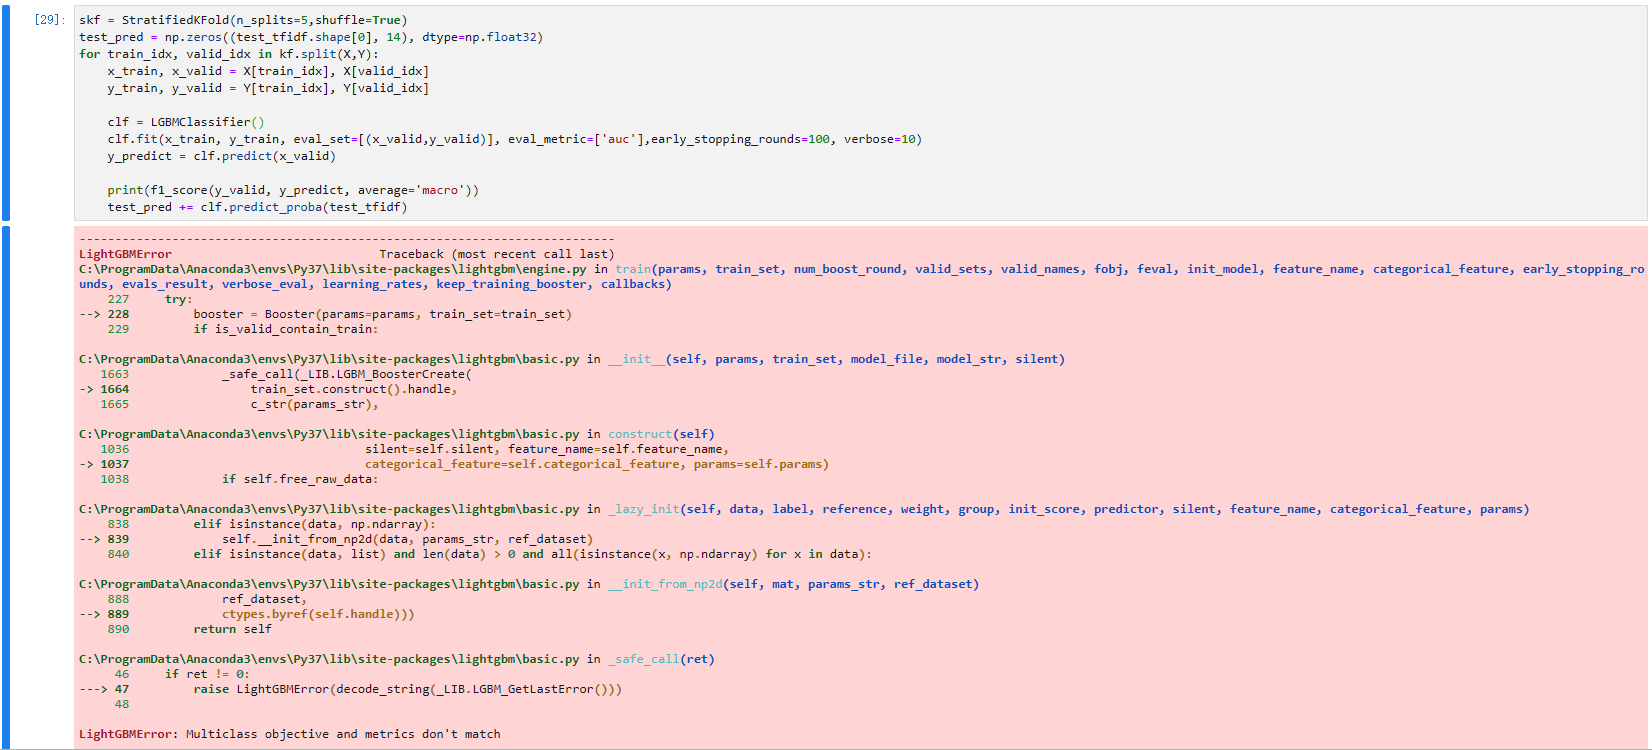